In [7]:
library(survminer)
library(survival)
library(forestplot)
library(ggsci)

plotSurv <- function(fit, data.df, legend.title, legend.labs){
    p <- ggsurvplot(
        fit,                    
        data = data.df,
        risk.table = TRUE,
        pval = TRUE,
        conf.int = TRUE,
        xlab = "Time (Months)",
        break.time.by = 100,
        risk.table.y.text.col = T,
        risk.table.y.text = F,
        legend.title = legend.title,
        legend.labs = legend.labs,
    )
    
    return(p)
}

In [13]:
data.df <- read.table("data/processed/dataset_processed.tsv", sep="\t", header=T)
data.df <- data.df[data.df$Kappa_or_lambda_PCD %in% c("L","K"),]

#
dat.df <- data.df[data.df$BU__BNP_based__cardiac_staging %in% c("stage I","stage II","stage III","stage IIIb"),]
dat.df$BU__BNP_based__cardiac_staging <- as.factor(dat.df$BU__BNP_based__cardiac_staging)

### 1a. Cox Regression w/ Full Dataset
---

In [159]:
cox_model <- coxph(Surv(time, status) ~ Amyloid_type + Kappa_or_lambda_PCD + Age + Sex + Race, data=data.df)
obj <- ggforest(cox_model)

ggsave("figures/full_dataset_coxph_forest.pdf", plot = obj, width = 7, height = 8)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


In [160]:
cox_model <- coxph(Surv(time, status) ~ Amyloid_type + Kappa_or_lambda_PCD + Age + Sex + Primary_organ + Secondary_organ, 
                   data=data.df[data.df$Primary_organ!="",])
obj <- ggforest(cox_model)
ggsave("figures/full_dataset_coxph_forest_organ.pdf", plot = obj, width = 7, height = 10)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


### 1b. Survival Curves w/ Full Dataset
---

In [115]:
fit <- survfit(Surv(time, status) ~ Amyloid_type, data=data.df)

pdf("figures/full_dataset_surv_amyloid_type.pdf", width=6, height=6) 
plotSurv(fit, data.df, legend.title="Amyloid",legend.labs=c("AL", "B-cell", "MM", "WM"))
dev.off()

pdf 
  2

In [116]:
fit <- survfit(Surv(time, status) ~ BU__BNP_based__cardiac_staging, data=dat.df)

pdf("figures/full_dataset_surv_bustage.pdf", width=6, height=6) 
plotSurv(fit, data.df, "BU Staging", c("stage I","stage II","stage III","stage IIIb"))
dev.off()

pdf 
  2

### 2a. Cox Regression w/ AL Dataset
---

* Using `mice` imputed dataset to `consensusClusterPlus`

In [14]:
data.df <- data.df[data.df$Amyloid_type=="AL",]

In [15]:
clust.df <- read.table("data/processed/AL_with_ccp_03.tsv", sep="\t", header=T, row.names='Code.ID')
data.df$cluster <- clust.df[as.character(data.df$Code.ID),"cluster"]

# assign cluster to var
data.df$cluster <- as.factor(data.df$cluster)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


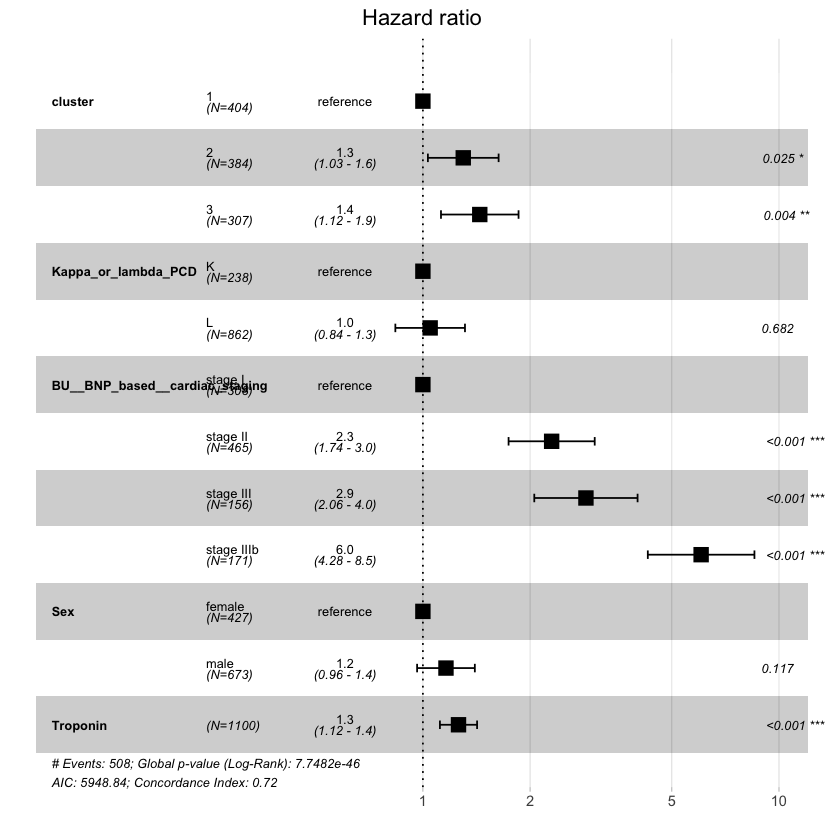

In [5]:
cox_model <- coxph(Surv(time, status) ~ cluster + Kappa_or_lambda_PCD + BU__BNP_based__cardiac_staging + Sex + Troponin, 
                   data=data.df[data.df$BU__BNP_based__cardiac_staging %in% c("stage I","stage II","stage III","stage IIIb"),])
ggforest(cox_model)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


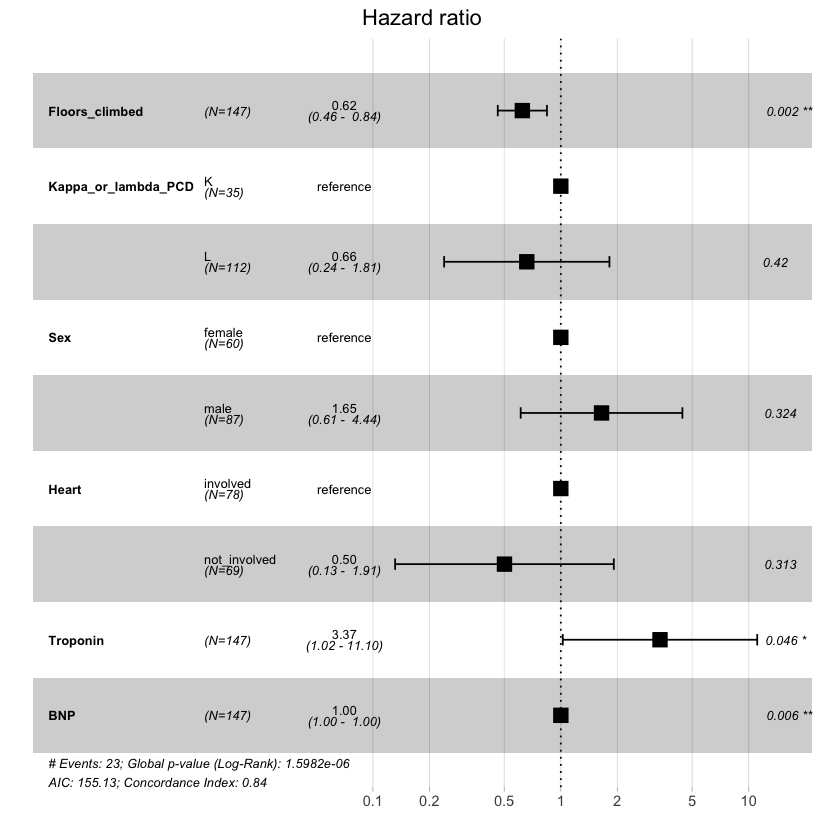

In [202]:
#data.df$Distance_walked==N

dat.df <- data.df[!is.na(data.df$Floors_climbed),]

cox_model <- coxph(Surv(time, status) ~ Floors_climbed + Kappa_or_lambda_PCD + Sex + Heart + Troponin + BNP, data = dat.df)
ggforest(cox_model)

In [171]:
cox_model <- coxph(Surv(time, status) ~  Kappa_or_lambda_PCD + Age + Sex, data = data.df)
obj <- ggforest(cox_model)

ggsave("figures/AL_dataset_coxph_forest.pdf", plot = obj, width = 6, height = 4)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


In [174]:
cox_model <- coxph(Surv(time, status) ~ cluster + Kappa_or_lambda_PCD + Age + Sex + Primary_organ, data=data.df)
obj <- ggforest(cox_model)
ggsave("figures/AL_dataset_coxph_clust_forest.pdf", plot = obj, width = 7, height = 8)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


In [178]:
cox_model <- coxph(Surv(time, status) ~ cluster + BU__BNP_based__cardiac_staging, 
                   data=data.df[data.df$BU__BNP_based__cardiac_staging %in% c("stage I","stage II","stage III","stage IIIb"),])
obj <- ggforest(cox_model)
ggsave("figures/AL_coxph_clust_bu_forest.pdf", plot = obj, width = 7, height = 8)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


In [ ]:
cox_model <- coxph(Surv(time, status) ~ cluster + BU__BNP_based__cardiac_staging, data=data.df)
ggforest(cox_model)

### 2b. Survival
---

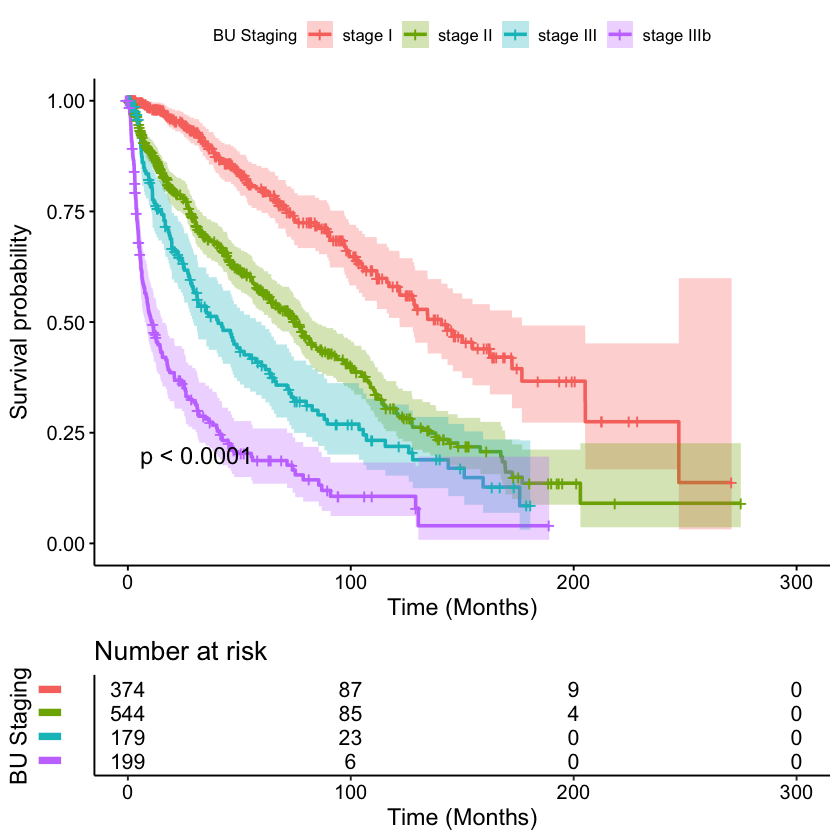

In [17]:
fit <- survfit(Surv(time, status) ~ BU__BNP_based__cardiac_staging, data=dat.df)

#pdf("figures/AL_dataset_surv_bustage.pdf", width=6, height=6) 
plotSurv(fit, dat.df, "BU Staging", c("stage I","stage II","stage III","stage IIIb"))
#dev.off()

In [18]:
fit <- survfit(Surv(time, status) ~ cluster, data=data.df)

pdf("figures/AL_dataset_surv_cluster.pdf", width=6, height=6) 
plotSurv(fit, data.df, legend.title="Cluster",legend.labs=c("1", "2", "3"))
dev.off()


pdf 
  2